# density-9999不够大，无法体现差异性

要点梳理：
- 剔除云层遮挡和数据缺失的情况

拖山的经度和纬度是(120.14,31.406)，兰山嘴的经度和纬度是(119.89,31.212)。我需要分析这2个点位逐日的叶绿素a浓度，请你修改下面的代码。如果受到云层影响导致数据缺失，请你用NAN代替。

创新点在于，将云层覆盖的区域设置为999999，这样在后续处理中可以很容易地识别出这些区域。

https://engine-aiearth.aliyun.com/docs/page/api?d=07f36f#heading-22

https://engine-aiearth.aliyun.com/?spm=a2cvf.28031243.0.0.5dc743d42pbV5o#/utility/auth-token

In [1]:
import aie

aie.Authenticate(token='8f04bf5ebc3b343fcfc4373fd0dd4a33')
aie.Initialize()

计算资源初始化中，请等待...
计算资源初始化完成.


In [2]:
import geopandas as gpd

In [3]:
# 读取shp文件
shapefile_path = '/root/Download/Modis-algae-aliyun/local-data/taihu.shp'
gdf = gpd.read_file(shapefile_path)

# 假设shp文件中只有一个几何对象，取第一个
geometry = gdf.geometry.iloc[0]
print(geometry)
# 输出((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, ...

# 将geopandas的geometry对象转换为ee.Geometry
coords = list(geometry.exterior.coords)
flattened_coords = [coord for point in coords for coord in point]
taihu = aie.Geometry.Polygon(flattened_coords)
# 构造Polygon。输入参数支持GeoJSON 'Polygon'类型格式的坐标点集，
# 同时也支持包含偶数个数字的一维List，例如aie.Geometry.Polygon([aLng, aLat, bLng, bLat, ...])。
# 需注意，输入的坐标点将以EPSG:4326坐标系进行解析。

# 打印ee.Geometry对象以验证
print(taihu)

POLYGON ((119.95082568376117 31.341888097180494, 119.98639104240964 31.388554715968827, 120.00611934273043 31.40820067954559, 120.0213482061359 31.420557311454473, 120.02780893606551 31.42562749019076, 120.03023170978913 31.42966374717613, 120.0274051404449 31.43596389857637, 120.02025218945138 31.447873965243872, 120.00888822698595 31.45166321445573, 120.01067646473432 31.455403102339847, 120.01448368058568 31.46224277412878, 120.01806015608244 31.467556706624215, 120.02342486932757 31.473017934057427, 120.02827041677476 31.47729813281918, 120.02902032292732 31.479561147303205, 120.03525031250228 31.481725718642263, 120.03871141782174 31.48452974796941, 120.04223020822982 31.48275879185581, 120.04678733023371 31.479659537995836, 120.05734370145801 31.476461787529658, 120.06017027080222 31.47651098451827, 120.06380443138762 31.471541958062947, 120.06276609979179 31.468442332717288, 120.06345832085567 31.46578542930369, 120.06703479635243 31.4656870240255, 120.07078432711515 31.46052060

# 计算完整的7月份

你这个逻辑还是有问题，请你用伪代码的方式，提供一个代码的逻辑框架，please think by chain-of-thought：


我需要你同步输出modis反演的藻密度和lanshanzui.csv'中的藻密度，使得二者之间的差距尽可能小。由于lanshanzui.csv'中的藻密度一天会产生6个值，因此lanshanzui.csv'中的藻密度将采用置信区间的形式，modis反演的藻密度将与“lanshanzui.csv'中的藻密度将采用置信区间”进行比较

请你分析并修改这段代码，我的顾虑是："""这段代码好像是通过2022年7月逐日的计算值逐步优化参数，应该根据遥感影像的sample的完整的2022年7月的结果一起计算？输出一个最终的优化参数？"""

需要你注意如下2种情况将不作为参数优化的计算依据：
- MODIS遥感影像中藻密度为9999.0，也就是云层遮挡的情况
- df['density']中数据缺失的情况。


## demo-1.0版本-计算失败

/tmp/ipykernel_31149/1116589033.py:55: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/1116589033.py:55: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/1116589033.py:55: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/1116589033.py:55: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/1116589033.py:55: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/1116589033.py:55: UserWarning: Glyph 31867 (\N{CJK UNIFIED IDEOGRAPH-7C7B}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/1116589033.py:55: UserWarning: Glyph 21450 (\N{CJK UNIFIED IDEOGRAPH-53CA}) missing from current font.
  plt.

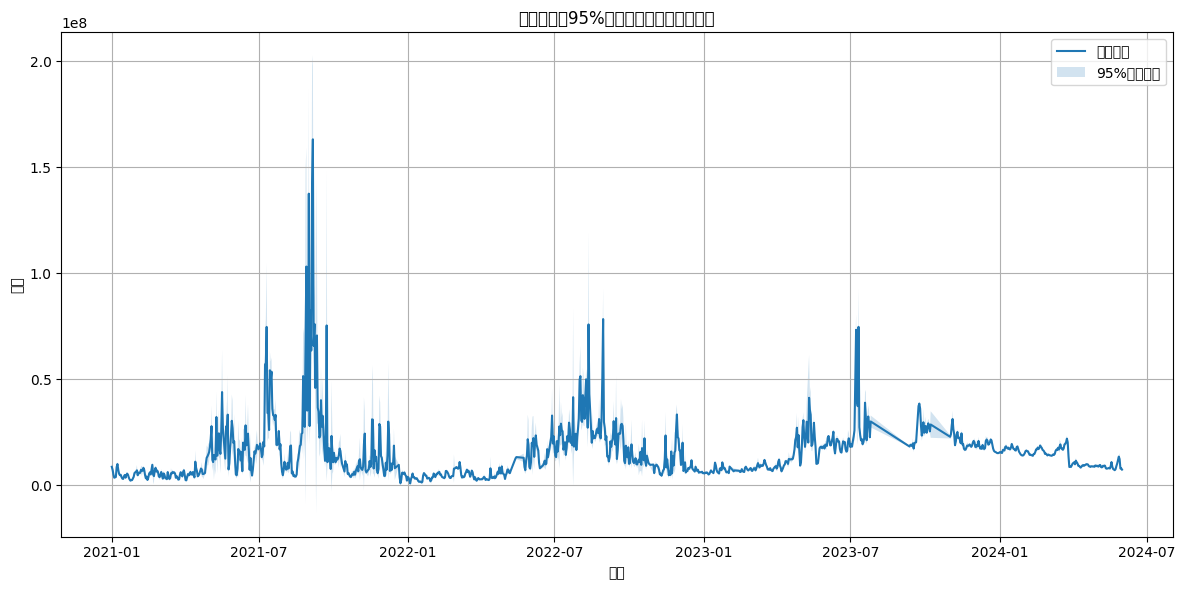

In [4]:
import datetime
import csv
import aie
import pandas as pd
import numpy as np
import chardet
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# 步骤1: 数据准备
csv_file = '/root/Download/Modis-algae-aliyun/aie-taihu/00-lanshanzui.csv'

# 检测文件编码
with open(csv_file, 'rb') as f:
    result = chardet.detect(f.read())

# 使用探测到的编码读取文件
df = pd.read_csv(csv_file, encoding=result['encoding'])

# 将日期列转换为日期时间格式
df['date'] = pd.to_datetime(df['date'])

# 设置日期为索引
df.set_index('date', inplace=True)

# 对密度列进行线性插值
df['density'] = df['density'].interpolate(method='linear')

# 按日期分组并计算每日的统计数据
daily_stats = df['density'].resample('D').agg(['mean', 'std', 'count'])

# 计算95%置信区间
confidence_interval = 1.96 * daily_stats['std'] / np.sqrt(daily_stats['count'])

# 计算置信区间的上下限
daily_stats['lower_ci'] = daily_stats['mean'] - confidence_interval
daily_stats['upper_ci'] = daily_stats['mean'] + confidence_interval

# 对平均值和置信区间上下限进行线性插值
daily_stats_interpolated = daily_stats.interpolate(method='linear')

# 绘制密度和置信区间
plt.figure(figsize=(12, 6))
plt.plot(daily_stats_interpolated.index, daily_stats_interpolated['mean'], label='平均密度')
plt.fill_between(daily_stats_interpolated.index, daily_stats_interpolated['lower_ci'], daily_stats_interpolated['upper_ci'], alpha=0.2, label='95%置信区间')
plt.xlabel('日期')
plt.ylabel('密度')
plt.title('藻类密度及95%置信区间（线性插值后）')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 收集MODIS所有有效数据

In [5]:

# 步骤2: 收集所有有效数据
valid_features = {
    'ndci': [],
    'ndvi': [],
    'evi': [],
    'ndwi': [],
    'b1': [],
    'b2': [],
    'b5': []
}
valid_density_mean = []
valid_density_lower = []
valid_density_upper = []

roi = aie.Geometry.BBox(119.89, 31.212, 119.90, 31.222)

def mask_clouds(image):
    qa = image.select('state_1km')
    cloud_bit_mask = 1 << 10
    mask = qa.bitwiseAnd(aie.Image.constant(cloud_bit_mask))
    return mask

## 加载已保存的数据版本

In [6]:

from aiearth.core.error.aie_error import AIEError
from requests.exceptions import ReadTimeout
import pickle
import datetime

# 加载已保存的数据（如果存在）
try:
    current_date = datetime.date.today()
    filename = f'saved_data_{current_date.strftime("%Y%m%d")}.pkl'
    with open(filename, 'rb') as f:
        saved_data = pickle.load(f)
    valid_features = saved_data['valid_features']
    valid_density_mean = saved_data['valid_density_mean']
    valid_density_lower = saved_data['valid_density_lower']
    valid_density_upper = saved_data['valid_density_upper']
    start_date = saved_data['start_date']
    print(f"已加载保存的数据 {filename}，从", start_date, "继续")
except FileNotFoundError:
    print("未找到保存的数据，从头开始")

未找到保存的数据，从头开始


## valid_features线性插值



In [8]:
start_date = datetime.date(2021, 1, 1)
end_date = datetime.date(2023, 12, 31)
delta = datetime.timedelta(days=1)
valid_dates = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    retry_count = 0
    while retry_count < 10:
        try:
            img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
                     .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
            
            cloud_mask = mask_clouds(img)
            ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
            ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
            evi = img.expression(
                '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
            ).rename(['evi'])
            ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
            
            ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            
            current_date = pd.to_datetime(start_date)
            if current_date in daily_stats_interpolated.index:
                mean_density = daily_stats_interpolated.loc[current_date, 'mean']
                lower_ci = daily_stats_interpolated.loc[current_date, 'lower_ci']
                upper_ci = daily_stats_interpolated.loc[current_date, 'upper_ci']
                
                ndci_values = ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo()
                ndvi_values = ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo()
                evi_values = evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo()
                ndwi_values = ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo()
                b1_values = b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo()
                b2_values = b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo()
                b5_values = b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
                
                valid_indices = [i for i in range(len(ndci_values)) if ndci_values[i] < 999999999]
                
                if valid_indices:
                    valid_features['ndci'].extend([ndci_values[i] for i in valid_indices])
                    valid_features['ndvi'].extend([ndvi_values[i] for i in valid_indices])
                    valid_features['evi'].extend([evi_values[i] for i in valid_indices])
                    valid_features['ndwi'].extend([ndwi_values[i] for i in valid_indices])
                    valid_features['b1'].extend([b1_values[i] for i in valid_indices])
                    valid_features['b2'].extend([b2_values[i] for i in valid_indices])
                    valid_features['b5'].extend([b5_values[i] for i in valid_indices])
                    valid_density_mean.extend([mean_density] * len(valid_indices))
                    valid_density_lower.extend([lower_ci] * len(valid_indices))
                    valid_density_upper.extend([upper_ci] * len(valid_indices))
                    valid_dates.extend([current_date] * len(valid_indices))
            break  # 如果成功处理数据，跳出重试循环
        except AIEError as e:
            print(f"处理日期 {date_str} 的数据时出错 (尝试 {retry_count + 1}/10): {str(e)}")
            retry_count += 1
            if retry_count == 10:
                print(f"无法处理日期 {date_str} 的数据，已达到最大重试次数")
    
    start_date += delta


处理日期 2021_04_30 的数据时出错 (尝试 1/10): 系统未知异常. {"taskId": "6803ba9a-913f-11ef-9069-00155d224ff9"}
处理日期 2021_07_10 的数据时出错 (尝试 1/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "1afac54a-9144-11ef-9069-00155d224ff9"}
处理日期 2021_07_10 的数据时出错 (尝试 2/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "1d6b420a-9144-11ef-9069-00155d224ff9"}
处理日期 2021_07_10 的数据时出错 (尝试 3/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "1fe03216-9144-11ef-9069-00155d224ff9"}
处理日期 2021_07_10 的数据时出错 (尝试 4/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "22173516-9144-11ef-9069-00155d224ff9"}
处理日期 2021_07_10 的数据时出错 (尝试 5/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "246a6d2e-9144-11ef-9069-00155d224ff9"}
处理日期 2021_07_10 的数据时出错 (尝试 6/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "269de4c2-9144-11ef-9069-00155d224ff9"}
处理日期 2021_07_10 的数据时出错 (尝试 7/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "29082434-9144-11ef-9069-00155

有效样本数量: 758
ndci范围: -0.35449734330177307 到 2.6393442153930664
ndvi范围: -3.65116286277771 到 0.7472863793373108
evi范围: -117.2727279663086 到 72.5
ndwi范围: -1.8823529481887817 到 0.714628279209137
b1范围: -100.0 到 10107.0
b2范围: -100.0 到 10261.0
b5范围: -100.0 到 9278.0
密度均值范围: 883806.25 到 163216666.66666666
密度下限范围: -13413189.365475483 到 123567447.01342365
密度上限范围: 1036964.4210208628 到 202865886.31990966


/tmp/ipykernel_31149/3978715439.py:39: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:39: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:39: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:39: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:39: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:39: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:39: UserWarning: Glyph 21644 (\N{CJK UNIFIED IDEOGRAPH-548C}) missing from current font.
  plt.

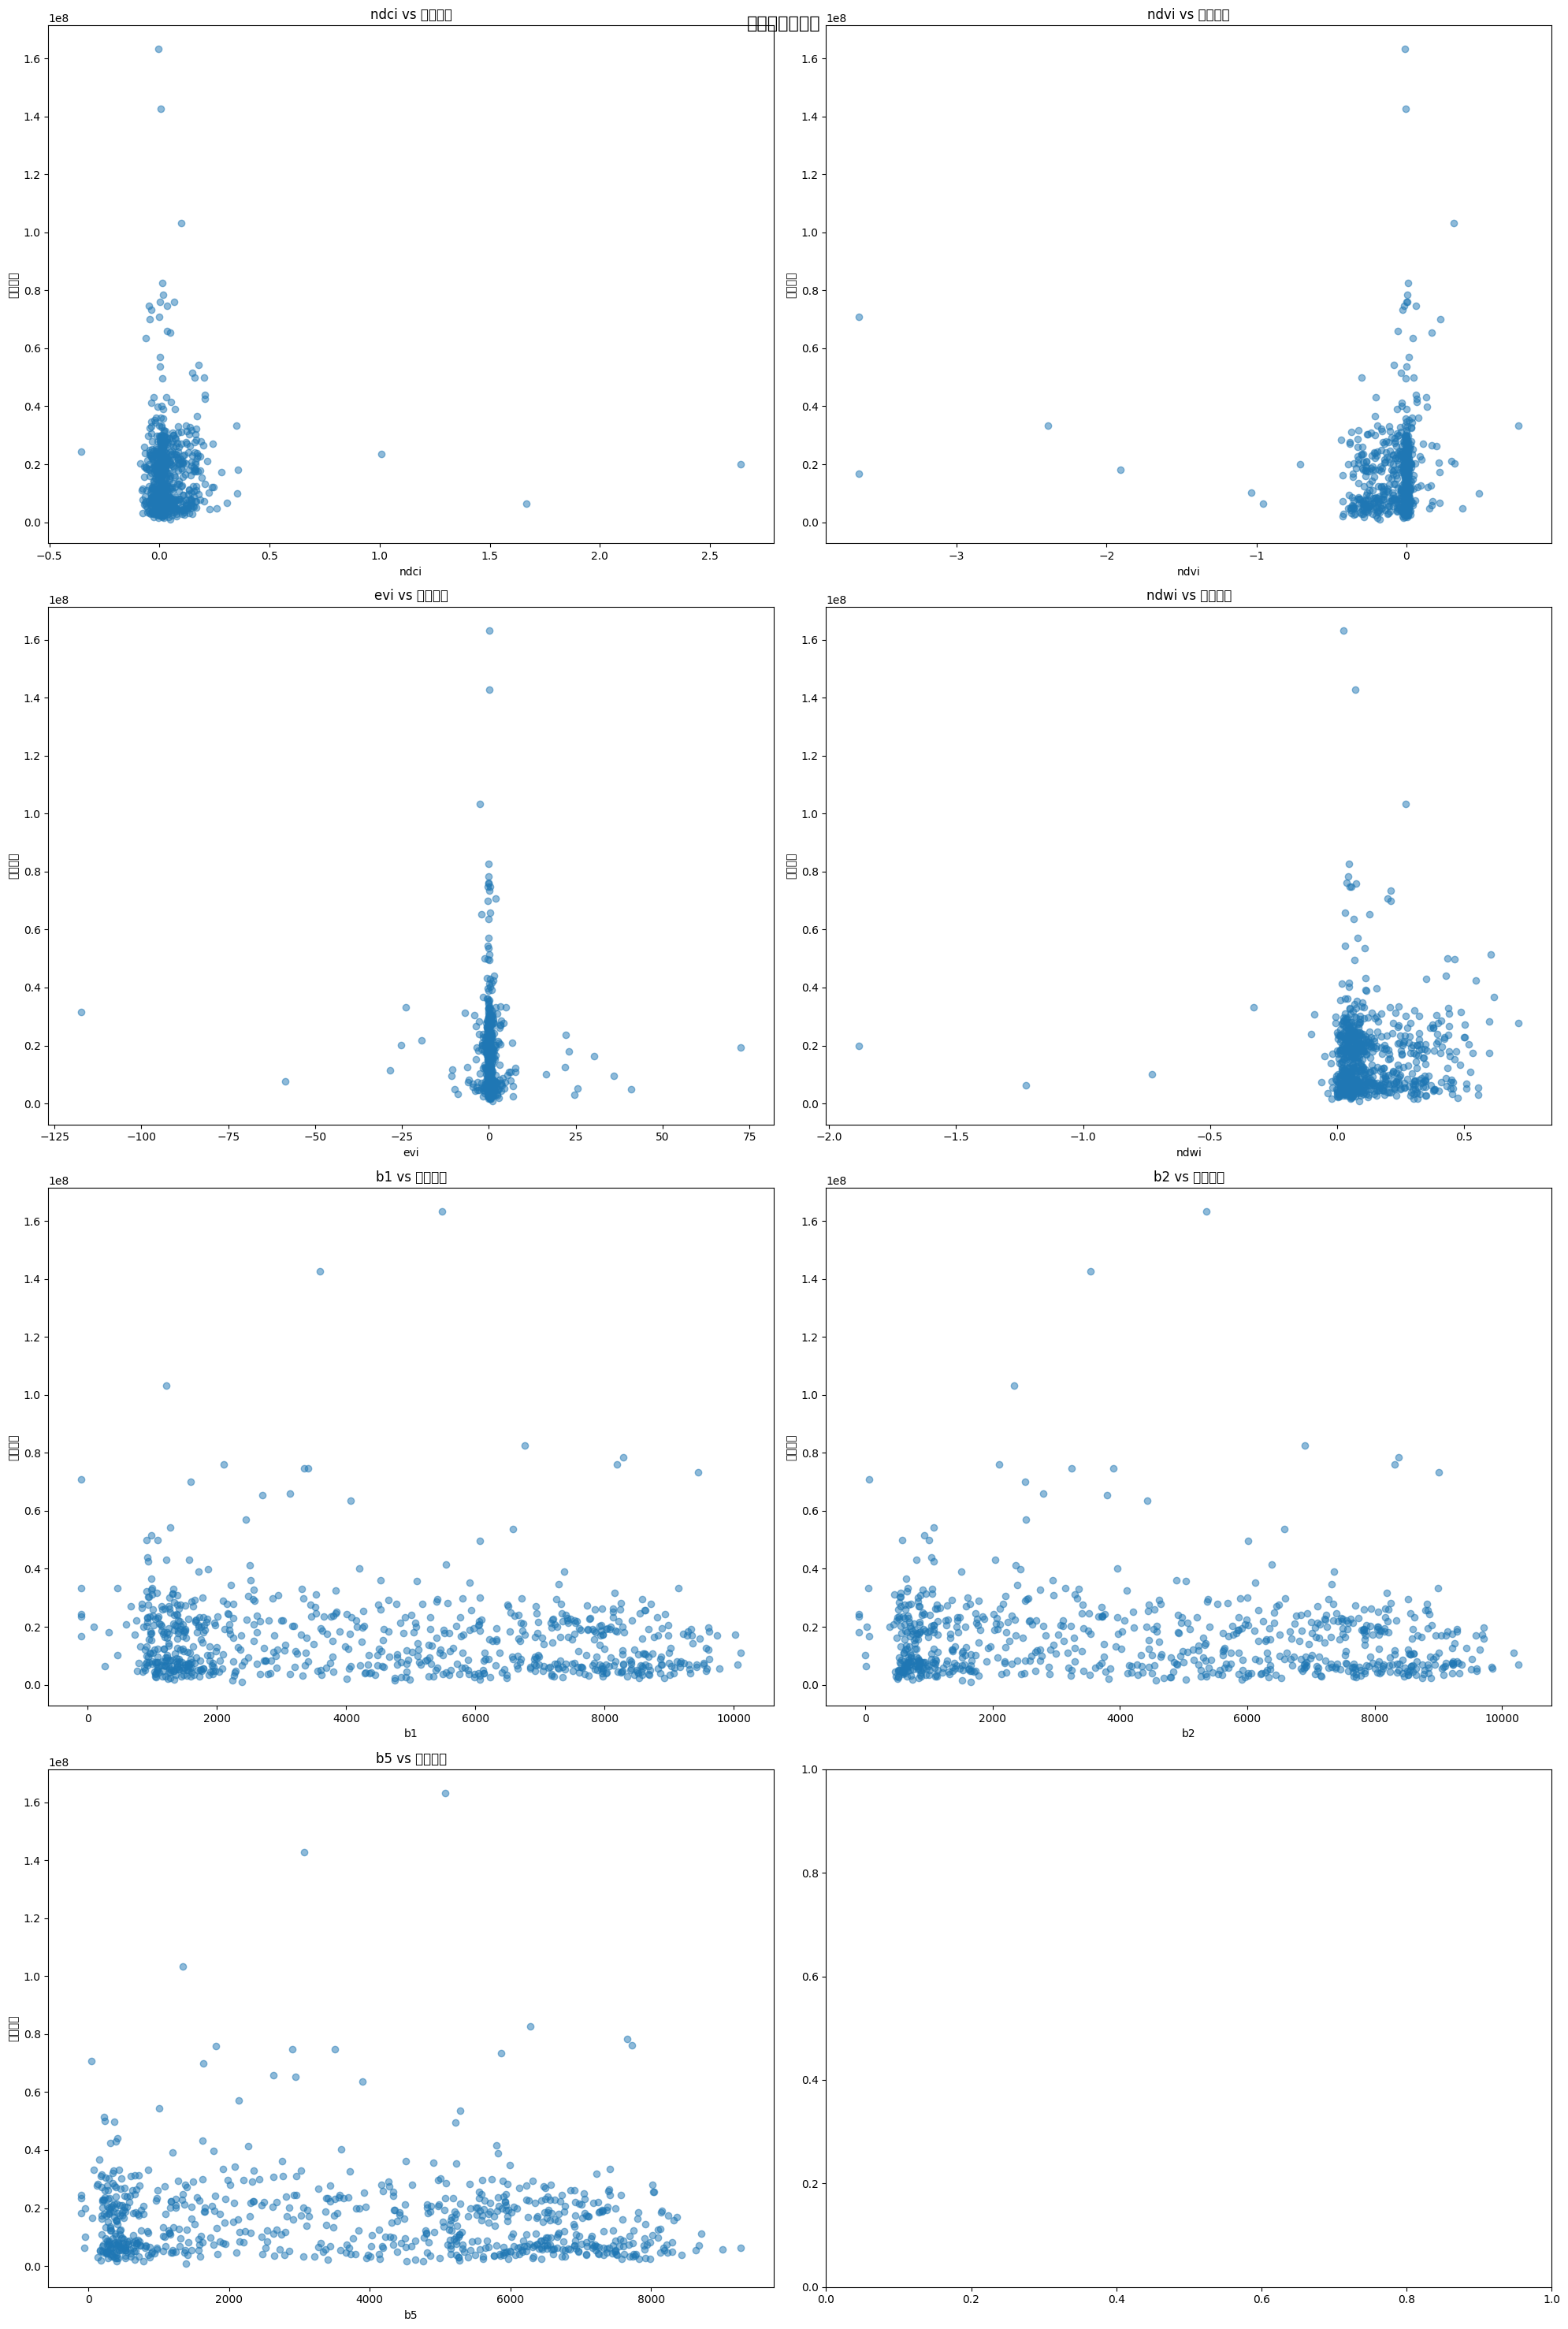

/tmp/ipykernel_31149/3978715439.py:53: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:53: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:53: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:53: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:53: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:53: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_31149/3978715439.py:53: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.

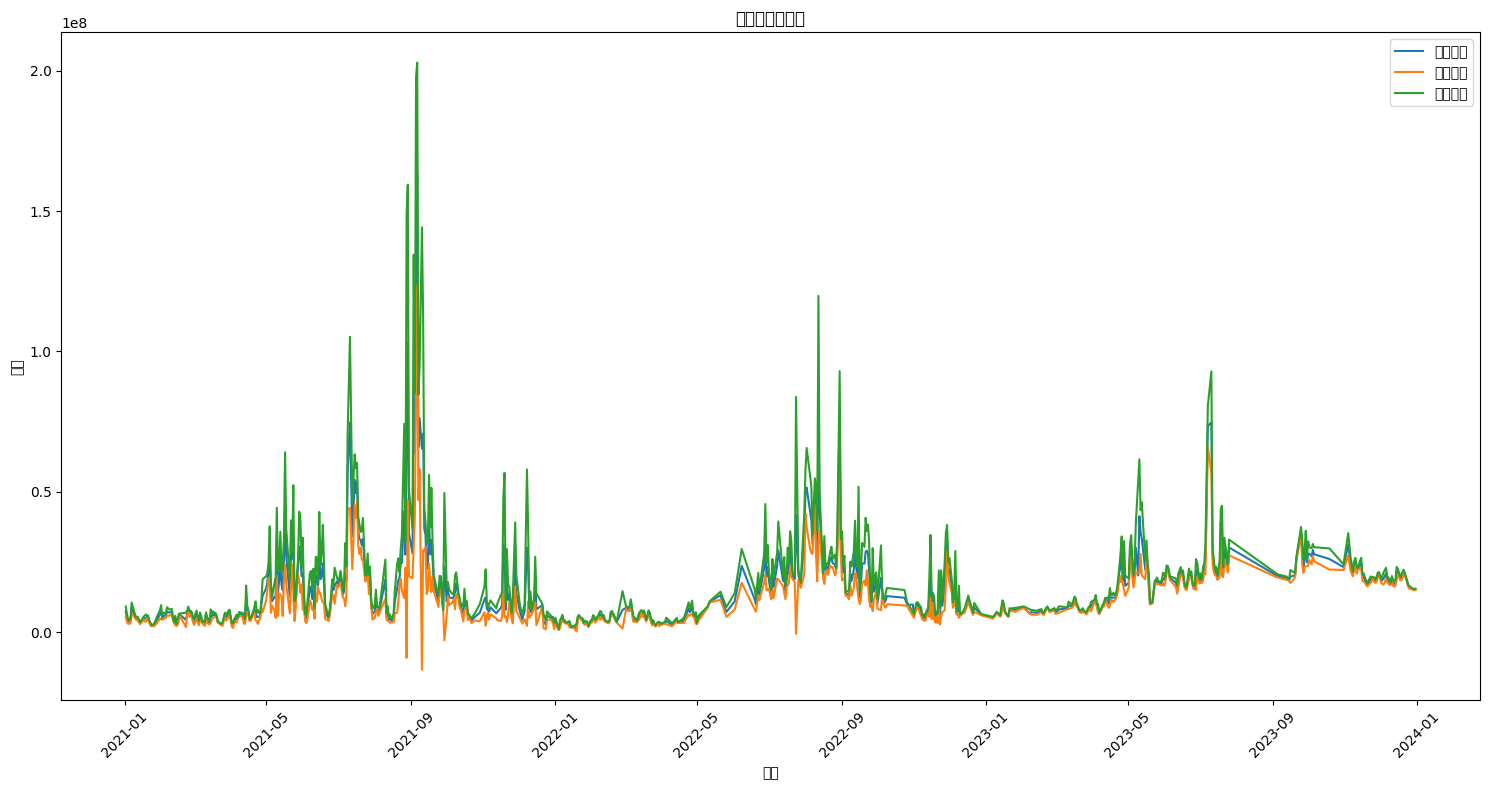

缺失日期数量: 336
缺失日期比例: 30.71%
缺失日期:
DatetimeIndex(['2021-01-08', '2021-01-09', '2021-01-13', '2021-01-15',
               '2021-01-18', '2021-01-29', '2021-01-30', '2021-02-07',
               '2021-02-09', '2021-02-18',
               ...
               '2023-11-22', '2023-11-24', '2023-12-01', '2023-12-03',
               '2023-12-05', '2023-12-08', '2023-12-17', '2023-12-22',
               '2023-12-24', '2023-12-28'],
              dtype='datetime64[ns]', length=336, freq=None)

结果已保存到 '特征和密度结果-date.csv'


In [11]:
# 打印收集到的数据统计信息
print(f"有效样本数量: {len(valid_features['ndci'])}")
for key in valid_features.keys():
    if valid_features[key]:
        print(f"{key}范围: {min(valid_features[key])} 到 {max(valid_features[key])}")
    else:
        print(f"{key}范围: 无有效数据")
if valid_density_mean:
    print(f"密度均值范围: {min(valid_density_mean)} 到 {max(valid_density_mean)}")
else:
    print("密度均值范围: 无有效数据")
if valid_density_lower:
    print(f"密度下限范围: {min(valid_density_lower)} 到 {max(valid_density_lower)}")
else:
    print("密度下限范围: 无有效数据")
if valid_density_upper:
    print(f"密度上限范围: {min(valid_density_upper)} 到 {max(valid_density_upper)}")
else:
    print("密度上限范围: 无有效数据")

# 绘制valid_features和valid_density结果
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(20, 30))
fig.suptitle('特征和密度分布', fontsize=16)

for i, feature in enumerate(valid_features.keys()):
    row = i // 2
    col = i % 2
    if valid_features[feature] and valid_density_mean:
        axs[row, col].scatter(valid_features[feature], valid_density_mean, alpha=0.5)
        axs[row, col].set_xlabel(feature)
        axs[row, col].set_ylabel('密度均值')
        axs[row, col].set_title(f'{feature} vs 密度均值')
    else:
        axs[row, col].text(0.5, 0.5, '无有效数据', ha='center', va='center')
        axs[row, col].set_title(f'{feature} vs 密度均值 (无数据)')

plt.tight_layout()
plt.savefig('特征和密度分布.png')
plt.show()
# 绘制时间序列图
if valid_dates and valid_density_mean and valid_density_lower and valid_density_upper:
    plt.figure(figsize=(15, 8))
    plt.plot(valid_dates, valid_density_mean, label='密度均值')
    plt.plot(valid_dates, valid_density_lower, label='密度下限')
    plt.plot(valid_dates, valid_density_upper, label='密度上限')
    plt.xlabel('日期')
    plt.ylabel('密度')
    plt.title('藻密度时间序列')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('藻密度时间序列.png')
    plt.show()
else:
    print("无足够的有效数据来绘制时间序列图")

# 将结果保存到CSV
if valid_features['ndci']:
    results_df = pd.DataFrame(valid_features)
    results_df['density_mean'] = valid_density_mean
    results_df['density_lower'] = valid_density_lower
    results_df['density_upper'] = valid_density_upper
    results_df['date'] = valid_dates

    # 计算并打印缺失值的数量和比例
    date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    missing_dates = date_range.difference(results_df['date'])
    missing_count = len(missing_dates)
    total_days = (max(valid_dates) - min(valid_dates)).days + 1
    missing_percentage = 100 * missing_count / total_days
    
    print(f"缺失日期数量: {missing_count}")
    print(f"缺失日期比例: {missing_percentage:.2f}%")
    print("缺失日期:")
    print(missing_dates)

    results_df.to_csv('特征和密度结果-date.csv', index=False)
    print("\n结果已保存到 '特征和密度结果-date.csv'")
else:
    print("无有效数据可保存")

In [12]:
# 生成包含缺失日期的完整数据集并进行线性插值填充
if valid_features['ndci']:
    # 创建完整的日期范围
    full_date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    
    # 将现有数据转换为以日期为索引的DataFrame
    full_df = results_df.set_index('date')
    
    # 重新索引到完整的日期范围，这将自动为缺失的日期创建NaN值
    full_df = full_df.reindex(full_date_range)
    
    # 对所有列进行线性插值
    interpolated_df = full_df.interpolate(method='linear')
    
    # 重置索引，使日期成为一个列
    interpolated_df = interpolated_df.reset_index()
    interpolated_df = interpolated_df.rename(columns={'index': 'date'})
    
    # 保存插值后的结果到新的CSV文件
    interpolated_df.to_csv('特征和密度结果-插值填充.csv', index=False)
    print("\n插值填充后的结果已保存到 '特征和密度结果-插值填充.csv'")
    
    # 输出插值填充后的数据信息
    print(f"\n插值填充后的数据行数: {len(interpolated_df)}")
    print(f"插值填充前的数据行数: {len(results_df)}")
    print(f"填充的行数: {len(interpolated_df) - len(results_df)}")
else:
    print("无有效数据可进行插值填充")



插值填充后的结果已保存到 '特征和密度结果-插值填充.csv'

插值填充后的数据行数: 1094
插值填充前的数据行数: 758
填充的行数: 336


In [21]:
# 从线性插值的CSV文件中读取数据
interpolated_df = pd.read_csv('特征和密度结果-插值填充.csv')

# 将日期列转换为datetime类型
interpolated_df['date'] = pd.to_datetime(interpolated_df['date'])

# 准备训练数据
X = interpolated_df[['ndci', 'ndvi', 'evi', 'ndwi', 'b1', 'b2', 'b5']]
y_mean = interpolated_df['density_mean'].values
y_lower = interpolated_df['density_lower'].values
y_upper = interpolated_df['density_upper'].values

# 检查并移除包含NaN的行
mask = ~np.isnan(y_mean) & ~np.isnan(y_lower) & ~np.isnan(y_upper)
X = X[mask]
y_mean = y_mean[mask]
y_lower = y_lower[mask]
y_upper = y_upper[mask]
dates = interpolated_df['date'][mask]

# 准备LSTM模型数据
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# 检查GPU是否可用
print("GPU是否可用:", tf.test.is_gpu_available())

# 如果GPU不可用，可能有以下几个原因：
# 1. TensorFlow没有正确安装GPU版本
# 2. CUDA和cuDNN没有正确安装或版本不匹配
# 3. 环境变量设置问题
# 4. GPU驱动程序版本不兼容

# 尝试以下步骤来解决GPU不可用的问题：
# 1. 确保安装了GPU版本的TensorFlow：pip install tensorflow-gpu
# 2. 检查CUDA和cuDNN的安装和版本
# 3. 检查环境变量设置
# 4. 更新GPU驱动程序到最新版本

# 如果仍然无法使用GPU，可以尝试使用CPU进行训练
# 将所有 with tf.device('/GPU:0'): 替换为 with tf.device('/CPU:0'):

# 数据标准化
scaler_X = MinMaxScaler()
scaler_y_mean = MinMaxScaler()
scaler_y_lower = MinMaxScaler()
scaler_y_upper = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_mean_scaled = scaler_y_mean.fit_transform(y_mean.reshape(-1, 1))
y_lower_scaled = scaler_y_lower.fit_transform(y_lower.reshape(-1, 1))
y_upper_scaled = scaler_y_upper.fit_transform(y_upper.reshape(-1, 1))

# 创建时间窗口数据
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# 创建10天时间窗口的序列数据
X_seq, y_mean_seq = create_sequences(X_scaled, y_mean_scaled)
_, y_lower_seq = create_sequences(X_scaled, y_lower_scaled)
_, y_upper_seq = create_sequences(X_scaled, y_upper_scaled)

# 定义LSTM模型
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 训练LSTM模型
lstm_model_mean = create_lstm_model((X_seq.shape[1], X_seq.shape[2]))
lstm_model_mean.fit(X_seq, y_mean_seq, epochs=100, batch_size=32, verbose=0)

lstm_model_lower = create_lstm_model((X_seq.shape[1], X_seq.shape[2]))
lstm_model_lower.fit(X_seq, y_lower_seq, epochs=100, batch_size=32, verbose=0)

lstm_model_upper = create_lstm_model((X_seq.shape[1], X_seq.shape[2]))
lstm_model_upper.fit(X_seq, y_upper_seq, epochs=100, batch_size=32, verbose=0)

# 评估模型（使用训练数据，因为我们没有分割测试集）
y_mean_pred = lstm_model_mean.predict(X_seq)
y_lower_pred = lstm_model_lower.predict(X_seq)
y_upper_pred = lstm_model_upper.predict(X_seq)

# 反向转换预测结果
y_mean_pred = scaler_y_mean.inverse_transform(y_mean_pred)
y_lower_pred = scaler_y_lower.inverse_transform(y_lower_pred)
y_upper_pred = scaler_y_upper.inverse_transform(y_upper_pred)

y_mean_true = scaler_y_mean.inverse_transform(y_mean_seq)
y_lower_true = scaler_y_lower.inverse_transform(y_lower_seq)
y_upper_true = scaler_y_upper.inverse_transform(y_upper_seq)

print("均值模型 R-squared:", r2_score(y_mean_true, y_mean_pred))
print("下限模型 R-squared:", r2_score(y_lower_true, y_lower_pred))
print("上限模型 R-squared:", r2_score(y_upper_true, y_upper_pred))

print("均值模型 MSE:", mean_squared_error(y_mean_true, y_mean_pred))
print("下限模型 MSE:", mean_squared_error(y_lower_true, y_lower_pred))
print("上限模型 MSE:", mean_squared_error(y_upper_true, y_upper_pred))

print("注意：LSTM模型不直接提供特征重要性。如需特征重要性分析，可考虑使用其他方法，如排列重要性。")

print("LSTM模型训练完成")
print("可以使用这些模型来预测新的数据")



I0000 00:00:1729730692.233916   31149 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:03:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-24 08:44:52.234334: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


GPU是否可用: False
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


均值模型 R-squared: 0.40030852298906217
下限模型 R-squared: 0.45357773685100244
上限模型 R-squared: 0.5189534820238728
均值模型 MSE: 110013089599457.69
下限模型 MSE: 55212929214161.65
上限模型 MSE: 167639922997792.2
注意：LSTM模型不直接提供特征重要性。如需特征重要性分析，可考虑使用其他方法，如排列重要性。
LSTM模型训练完成
可以使用这些模型来预测新的数据
模型已保存，可以在未来加载使用


# 保存LSTM模型

In [22]:
import datetime

# 获取当前日期
current_date = datetime.datetime.now().strftime("%Y%m%d")

# 保存模型
lstm_model_mean.save(f'lstm_model_mean_{current_date}.h5')
lstm_model_lower.save(f'lstm_model_lower_{current_date}.h5')
lstm_model_upper.save(f'lstm_model_upper_{current_date}.h5')

print(f"模型已保存（日期：{current_date}），可以在未来加载使用")

模型已保存（日期：20241024），可以在未来加载使用


计算资源初始化中，请等待...
计算资源初始化完成.


## 2024年

In [ ]:
import aie

aie.Authenticate(token='a883697366926140b70e960b7a5f2a5f')
aie.Initialize()

In [26]:
start_date = datetime.date(2024, 1, 1)
end_date = datetime.date(2024, 5, 31)
delta = datetime.timedelta(days=1)
valid_dates = []

while start_date <= end_date:
    date_str = start_date.strftime("%Y_%m_%d")
    retry_count = 0
    while retry_count < 10:
        try:
            img = aie.Image(f'MODIS_MOD09GA_061_{date_str}')\
                     .select(['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'state_1km'])
            
            cloud_mask = mask_clouds(img)
            ndci = img.normalizedDifference(['sur_refl_b04', 'sur_refl_b03']).rename(['ndci'])
            ndvi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b01']).rename(['ndvi'])
            evi = img.expression(
                '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
                {'NIR': img.select('sur_refl_b02'), 'RED': img.select('sur_refl_b01'), 'BLUE': img.select('sur_refl_b03')}
            ).rename(['evi'])
            ndwi = img.normalizedDifference(['sur_refl_b02', 'sur_refl_b05']).rename(['ndwi'])
            
            ndci_masked = ndci.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            ndvi_masked = ndvi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            evi_masked = evi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            ndwi_masked = ndwi.where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b1_masked = img.select('sur_refl_b01').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b2_masked = img.select('sur_refl_b02').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            b5_masked = img.select('sur_refl_b05').where(cloud_mask.Not(), aie.Image.constant(999999999999))
            
            current_date = pd.to_datetime(start_date)
            if current_date in daily_stats_interpolated.index:
                mean_density = daily_stats_interpolated.loc[current_date, 'mean']
                lower_ci = daily_stats_interpolated.loc[current_date, 'lower_ci']
                upper_ci = daily_stats_interpolated.loc[current_date, 'upper_ci']
                
                ndci_values = ndci_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndci').getInfo()
                ndvi_values = ndvi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndvi').getInfo()
                evi_values = evi_masked.sample(roi, 100, 1, 0, True).aggregate_array('evi').getInfo()
                ndwi_values = ndwi_masked.sample(roi, 100, 1, 0, True).aggregate_array('ndwi').getInfo()
                b1_values = b1_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b01').getInfo()
                b2_values = b2_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b02').getInfo()
                b5_values = b5_masked.sample(roi, 100, 1, 0, True).aggregate_array('sur_refl_b05').getInfo()
                
                valid_indices = [i for i in range(len(ndci_values)) if ndci_values[i] < 999999999]
                
                if valid_indices:
                    valid_features['ndci'].extend([ndci_values[i] for i in valid_indices])
                    valid_features['ndvi'].extend([ndvi_values[i] for i in valid_indices])
                    valid_features['evi'].extend([evi_values[i] for i in valid_indices])
                    valid_features['ndwi'].extend([ndwi_values[i] for i in valid_indices])
                    valid_features['b1'].extend([b1_values[i] for i in valid_indices])
                    valid_features['b2'].extend([b2_values[i] for i in valid_indices])
                    valid_features['b5'].extend([b5_values[i] for i in valid_indices])
                    valid_density_mean.extend([mean_density] * len(valid_indices))
                    valid_density_lower.extend([lower_ci] * len(valid_indices))
                    valid_density_upper.extend([upper_ci] * len(valid_indices))
                    valid_dates.extend([current_date] * len(valid_indices))
            break  # 如果成功处理数据，跳出重试循环
        except AIEError as e:
            print(f"处理日期 {date_str} 的数据时出错 (尝试 {retry_count + 1}/10): {str(e)}")
            retry_count += 1
            if retry_count == 10:
                print(f"无法处理日期 {date_str} 的数据，已达到最大重试次数")
    
    start_date += delta

# 打印收集到的数据统计信息
print(f"有效样本数量: {len(valid_features['ndci'])}")
for key in valid_features.keys():
    if valid_features[key]:
        print(f"{key}范围: {min(valid_features[key])} 到 {max(valid_features[key])}")
    else:
        print(f"{key}范围: 无有效数据")
if valid_density_mean:
    print(f"密度均值范围: {min(valid_density_mean)} 到 {max(valid_density_mean)}")
else:
    print("密度均值范围: 无有效数据")
if valid_density_lower:
    print(f"密度下限范围: {min(valid_density_lower)} 到 {max(valid_density_lower)}")
else:
    print("密度下限范围: 无有效数据")
if valid_density_upper:
    print(f"密度上限范围: {min(valid_density_upper)} 到 {max(valid_density_upper)}")
else:
    print("密度上限范围: 无有效数据")

# 绘制valid_features结果
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, figsize=(20, 30))
fig.suptitle('特征分布 (2024年1月-5月)', fontsize=16)

for i, feature in enumerate(valid_features.keys()):
    row = i // 2
    col = i % 2
    if valid_features[feature]:
        axs[row, col].hist(valid_features[feature], bins=50)
        axs[row, col].set_xlabel(feature)
        axs[row, col].set_ylabel('频率')
        axs[row, col].set_title(f'{feature} 分布')
    else:
        axs[row, col].text(0.5, 0.5, '无有效数据', ha='center', va='center')
        axs[row, col].set_title(f'{feature} (无数据)')

plt.tight_layout()
plt.savefig('特征分布_2024年1月-5月.png')
plt.show()
# 绘制时间序列图
if valid_dates and valid_density_mean and valid_density_lower and valid_density_upper:
    plt.figure(figsize=(15, 8))
    plt.plot(valid_dates, valid_density_mean, label='密度均值')
    plt.plot(valid_dates, valid_density_lower, label='密度下限')
    plt.plot(valid_dates, valid_density_upper, label='密度上限')
    plt.xlabel('日期')
    plt.ylabel('密度')
    plt.title('藻密度时间序列')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('藻密度时间序列.png')
    plt.show()
else:
    print("无足够的有效数据来绘制时间序列图")

# 将结果保存到CSV
if valid_features['ndci']:
    results_df = pd.DataFrame(valid_features)
    results_df['density_mean'] = valid_density_mean
    results_df['density_lower'] = valid_density_lower
    results_df['density_upper'] = valid_density_upper
    results_df['date'] = valid_dates

    # 计算并打印缺失值的数量和比例
    date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    missing_dates = date_range.difference(results_df['date'])
    missing_count = len(missing_dates)
    total_days = (max(valid_dates) - min(valid_dates)).days + 1
    missing_percentage = 100 * missing_count / total_days
    
    print(f"缺失日期数量: {missing_count}")
    print(f"缺失日期比例: {missing_percentage:.2f}%")
    print("缺失日期:")
    print(missing_dates)

    results_df.to_csv('特征结果_2024年1月-5月.csv', index=False)
    print("\n结果已保存到 '特征结果_2024年1月-5月.csv'")
else:
    print("无有效数据可保存")

# 生成包含缺失日期的完整数据集并进行线性插值填充
if valid_features['ndci']:
    # 创建完整的日期范围
    full_date_range = pd.date_range(start=min(valid_dates), end=max(valid_dates))
    
    # 将现有数据转换为以日期为索引的DataFrame
    full_df = results_df.set_index('date')
    
    # 重新索引到完整的日期范围，这将自动为缺失的日期创建NaN值
    full_df = full_df.reindex(full_date_range)
    
    # 对所有列进行线性插值
    interpolated_df = full_df.interpolate(method='linear')
    
    # 重置索引，使日期成为一个列
    interpolated_df = interpolated_df.reset_index()
    interpolated_df = interpolated_df.rename(columns={'index': 'date'})
    
    # 保存插值后的结果到新的CSV文件
    interpolated_df.to_csv('特征结果_2024年1月-5月_插值填充.csv', index=False)
    print("\n插值填充后的结果已保存到 '特征结果_2024年1月-5月_插值填充.csv'")
    
    # 输出插值填充后的数据信息
    print(f"\n插值填充后的数据行数: {len(interpolated_df)}")
    print(f"插值填充前的数据行数: {len(results_df)}")
    print(f"填充的行数: {len(interpolated_df) - len(results_df)}")
else:
    print("无有效数据可进行插值填充")





处理日期 2024_01_05 的数据时出错 (尝试 1/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "07b2e162-91ed-11ef-9069-00155d224ff9"}
处理日期 2024_01_05 的数据时出错 (尝试 2/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "0a836c86-91ed-11ef-9069-00155d224ff9"}
处理日期 2024_01_05 的数据时出错 (尝试 3/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "0d23dec6-91ed-11ef-9069-00155d224ff9"}
处理日期 2024_01_05 的数据时出错 (尝试 4/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "0fddb9de-91ed-11ef-9069-00155d224ff9"}
处理日期 2024_01_05 的数据时出错 (尝试 5/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "129221ec-91ed-11ef-9069-00155d224ff9"}
处理日期 2024_01_05 的数据时出错 (尝试 6/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "153b81ae-91ed-11ef-9069-00155d224ff9"}
处理日期 2024_01_05 的数据时出错 (尝试 7/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"taskId": "17d4d2c6-91ed-11ef-9069-00155d224ff9"}
处理日期 2024_01_05 的数据时出错 (尝试 8/10): [AIEError]: 22801010, 输入属性不存在:ndci,存在的属性有:[]. {"t

ReadTimeout: HTTPSConnectionPool(host='engine-aiearth.aliyun.com', port=443): Read timed out. (read timeout=600)

请你读取这个模型和数据，并进行预测，绘制结果图，并输出一些统计信息。这里的LSTM的时间窗口是10天，也就是说，我们使用历史10天的数据，进行LSTM的时间卷积处理，来预测第10天的密度。最后绘制2024年的对比图，包括实际数据和预测数据